# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

### Gather observables

In [6]:
def f_get_plaquette(fname,dict1):
    
    try: 
        cmd="grep 'Plaquette' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string        

        arr=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), np.float64(i.split(' ')[-1])] 
                         for i in op])
        
        dict1['Plaquette']=arr[:,1]
        dict1['iter'] = arr[:,0]
        
    except Exception as e: 
        print("Couldn't extract Plaquette values")
        print(e)
    
    return dict1

def f_get_polyakov(fname,dict1):
    
    try: 
        cmd="grep 'Polyakov' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        arr=[]
        for i in op: 
            strg=i.split(' ')[-1][1:-1]
            arr.append(complex(np.float64(strg.split(',')[0]),np.float64(strg.split(',')[1])))
    
        dict1['Polyakov']=arr

    except Exception as e: 
        print("Couldn't extract Polyakov values")
        print(e)
    
    return dict1


def f_get_traj_time(fname,dict1):
    
    try: 
        cmd="grep 'Total time for trajectory' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string
        
        arr=[np.float32(i.split(': ')[-1]) for i in op]
        dict1['Traj_time']=arr

    except Exception as e: 
        print("Couldn't extract total Traj times")
        print(e)
        
    return dict1



def f_get_metropolis(fname,dict1,lgth):
    
    try: 
        cmd="grep 'Metropolis_test' %s"%(fname)
        op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
        op=[i for i in op if i] # Drop null string

        ## Other arrays have equilibriation data, metropolis doesn't. So we need to add nans to make them the same size
        arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
        skip=lgth-len(arr_temp)
        arr_skip=[np.nan for i in range(skip)]
        arr=np.array(arr_skip+arr_temp)
        dict1['Accept']=arr

    except Exception as e: 
        print("Couldn't extract total Metropolis info")
        print(e)
    
    return dict1

def f_parse_grid_data(fname):
    
    dict1={}
    
    f_get_plaquette(fname,dict1)
    
    f_get_polyakov(fname,dict1)
    
    f_get_traj_time(fname,dict1)

    lgth = min([len(i) for i in dict1.values()])
    f_get_metropolis(fname,dict1,lgth)

    ## Store in DataFrame
    df=pd.DataFrame([])
    for key in dict1.keys():
        df[key]=pd.Series(dict1[key])
        
    return df

# df=f_parse_grid_data(fname)

In [7]:


def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
    m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
    m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
    for i in range(1,5):
        m[i]=gv.dataset.avg_data(y**i)
        
    ## Check moments obtained by gvar, with direct calculation
#     n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
#     n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
#     for i in range(1,5):
#         arr=y**i
#         n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))
    
#     print(m)
#     print(n) 

#     print(m[2],m[1]**2)
    sus=(L**3)*(m[2]-(m[1]**2))
#     print(sus)

    if gv.mean(sus)>1e-12: # Don't measure if sus is 0
        kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
    else:
        kurt=gv.gvar(np.nan,np.nan)
        
    return sus,kurt


def f_get_summary_data(df,L,dict1):
    drop_idx=0
    
    ## Plaquette 
    if 'Plaquette' in df.columns:
        y=df.Plaquette.values[drop_idx:]
        dict1['plaq'] = gv.dataset.avg_data(y)
    
        # Susceptibility and Binder cumulant
        dict1['sus_plaq'],dict1['kurt_plaq']=f_moments(y,L)
    
    
    if 'Polyakov' in df.columns:
        ## Polyakov Loop
        y=np.abs(df.Polyakov.values[drop_idx:])
        dict1['polyakov']=gv.dataset.avg_data(y)

        # Susceptibility and Binder cumulant
        dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)

    
    ## Trajectory time
    if 'Traj_time' in df.columns:
        y=df.Traj_time.values[drop_idx:]
        dict1['traj_time']=gv.dataset.avg_data(y)
    
    ## Acceptance info
    
    if 'Accept' in df.columns:
        y=df['Accept'].dropna().values
        Act=y[y==1].shape[0]
        Rjt=y[y==0].shape[0]
        accpt=Act* 100 /(Act+Rjt)

        dict1['accept']=accpt
    
    return dict1



$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2}$$ 

In [8]:

data_dict={}
df_summary=pd.DataFrame([])

# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/scaling_tests/'
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/scaling_tests/'
flist=glob.glob(top_dir+'run_Lx-*')
# print(flist)

for run_fldr in flist[:]: 
    fname=run_fldr+'/HSDM1.out'
#     print(fname)
    
    if not os.path.isfile(fname): 
        print("File %s doesn't exist"%(fname))
        continue
    try: 
        df=f_parse_grid_data(fname)
#         display(df)
#         print(df.shape)
    
    except Exception as e: 
        print(e)
        continue
    
    ngpu=int(fname.split('/')[-2].split('gpu')[-2].split('_')[-1])
    Lx=int(fname.split('/')[-2].split('_Lx-')[-1].split('_')[0])
    Lt=int(fname.split('/')[-2].split('_Lt-')[-1].split('_')[0])

    vol_per_gpu=(Lx**3)*Lt/ngpu
    key='gpu-%s'%(ngpu)
    data_dict[key]=df

    # Get summary data
    dict2={'ngpu':ngpu,'Lx':Lx, 'Lt':Lt, 'vol_per_gpu':vol_per_gpu}
    dict2=f_get_summary_data(df,Lx,dict2)
    
#     print(dict2)
    df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
#     except Exception as e: 
#         print(fname)
#         print(e)
    

df_summary=df_summary.sort_values(by=['ngpu']).reset_index(drop=True)
display(df_summary)

KeyError: 'ngpu'

### Weak scaling 

In [9]:
## Pick runs with same Lx and Ly for weak scaling run
df=df_summary.copy()
lx=32;lt=16
df= df[(df.Lx==lx) & (df.Lt==lt)][['ngpu','traj_time']]

df['traj x gpu']=df.ngpu*df.traj_time
df

,ngpu,traj_time,traj x gpu
0,1,829.05(59),829.05(59)
1,2,404.72(18),809.44(35)
3,4,204.858(79),819.43(31)
5,8,129.270(61),1034.16(48)
7,16,79.170(27),1266.72(43)
9,32,47.363(11),1515.60(34)
11,64,37.6590(80),2410.18(51)


<IPython.core.display.Javascript object>


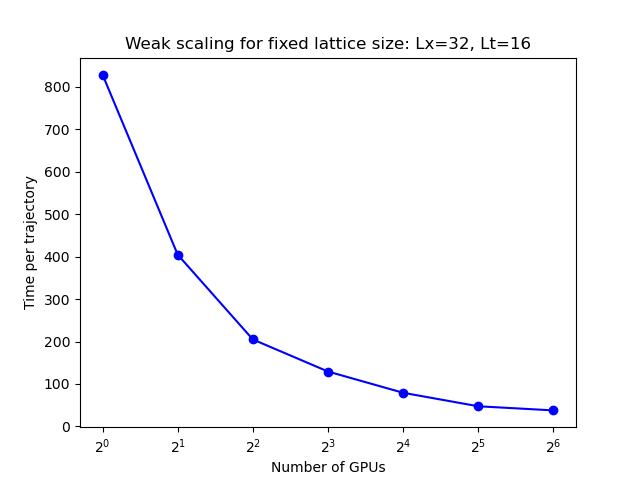

In [11]:
# plt.figure()
# x=df.ngpu.values
# y=df.traj_time.values*x

# plt.errorbar(x,gv.mean(y),gv.sdev(y),marker='o',color='b')
# plt.axhline(y=gv.mean(y)[0],color='k',linestyle='-.')
# plt.xticks(x)
# plt.ylabel("Time per trajectory * num GPUs")
# plt.xlabel('Number of GPUs')
# plt.title("Weak scaling for fixed lattice size: Lx=%s, Lt=%s"%(lx,lt))

# plt.xscale('log',base=2)

plt.figure()
x=df.ngpu.values
y=df.traj_time.values

plt.errorbar(x,gv.mean(y),gv.sdev(y),marker='o',color='b')
# plt.axhline(y=gv.mean(y)[0],color='k',linestyle='-.')
plt.xticks(x)
plt.ylabel("Time per trajectory")
plt.xlabel('Number of GPUs')
plt.title("Weak scaling for fixed lattice size: Lx=%s, Lt=%s"%(lx,lt))

plt.xscale('log',base=2)

plt.savefig("weak_scaling.pdf")

### Strong scaling

In [20]:
## Slice dataframe with max number of runs with same volume per gpu
df=df_summary.copy()
vol=df['vol_per_gpu'].value_counts().index[0]
df=df[df.vol_per_gpu==vol]
# df

<IPython.core.display.Javascript object>


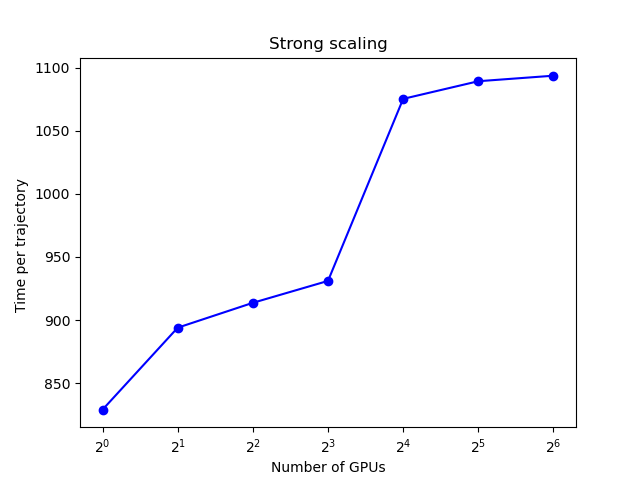

In [21]:
plt.figure()
x=df.ngpu.values
y=df.traj_time.values

plt.errorbar(x,gv.mean(y),gv.sdev(y),marker='o',color='b')

plt.ylabel("Time per trajectory ")
plt.xlabel('Number of GPUs')
plt.title("Strong scaling")

plt.xscale('log',base=2)
# plt.xticks(x)
plt.setp(x)
# plt.show()

plt.savefig("strong_scaling.pdf")